## **Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive

'11 - Custom Video Player.zip'	 lmao		  'Resume template.gdoc'
'Colab Notebooks'		 PasswordSafe.db   RTO_Question_Bank.pdf


**Get info of dataset**

In [ ]:
dataset = tfds.builder('eurosat')
info = dataset.info
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

Eurosat contains 2 datasets. We are using rgb datset

In [ ]:
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [ ]:
class_names = []
for i in range(info.features["label"].num_classes):
  class_names.append(info.features["label"].int2str(i))

class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
list(info.splits.keys())

['train']

This datset contains only one split train with 27000 images with 10 classes, You can get all these information in info which is mentioned above

## **Get Dataset**

In [ ]:
(train, val, test) = tfds.load("eurosat/rgb", split=["train[:80%]", "train[80%:90%]", "train[90%:]"])

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteRB42VI/eurosat-train.tfrecord


Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
type(train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
datapoint = next(iter(train))
datapoint

{'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'SeaLake_1558.jpg'>,
 'image': <tf.Tensor: shape=(64, 64, 3), dtype=uint8, numpy=
 array([[[ 53,  83, 111],
         [ 53,  83, 111],
         [ 56,  82, 115],
         ...,
         [ 54,  83, 113],
         [ 53,  84, 113],
         [ 54,  85, 114]],
 
        [[ 53,  83, 111],
         [ 53,  82, 112],
         [ 55,  81, 114],
         ...,
         [ 53,  84, 113],
         [ 53,  84, 113],
         [ 53,  84, 113]],
 
        [[ 54,  85, 114],
         [ 53,  84, 113],
         [ 54,  83, 115],
         ...,
         [ 53,  84, 112],
         [ 54,  85, 114],
         [ 53,  87, 115]],
 
        ...,
 
        [[ 55,  84, 114],
         [ 54,  85, 114],
         [ 56,  87, 116],
         ...,
         [ 52,  86, 114],
         [ 53,  84, 113],
         [ 54,  85, 114]],
 
        [[ 54,  85, 113],
         [ 55,  86, 114],
         [ 55,  86, 115],
         ...,
         [ 54,  85, 114],
         [ 56,  87, 116],
         [ 

This is a dictionary with 3 keys

## **Plot some images**

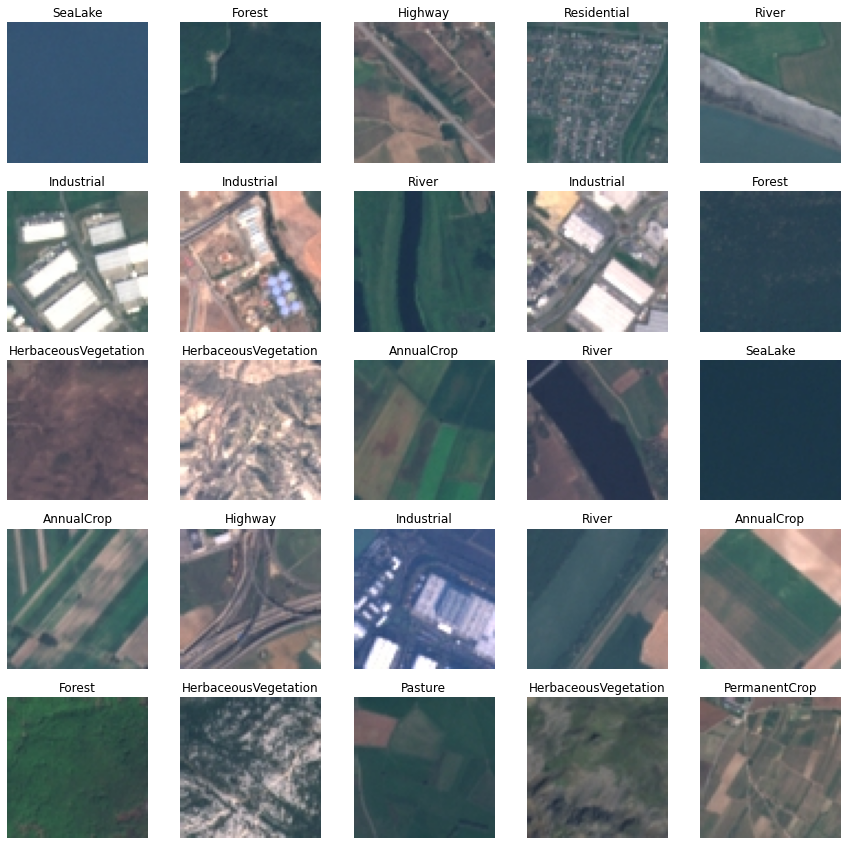

In [ ]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(train.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  plt.title(class_names[datapoint["label"]])
  plt.axis("off")
plt.show()

In [ ]:
NUM_EPOCHS = 5
BATCH_SIZE = 128
BUFFER_SIZE = 1000

IMAGE_SHAPE = [180, 180]
NUM_CLASSES = info.features["label"].num_classes

## **Data augmentation**

In [ ]:
tf.random.uniform(())  # This will generate a radom floating number from 0-1

<tf.Tensor: shape=(), dtype=float32, numpy=0.3792019>

In [ ]:
@tf.function
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)

  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

In [ ]:
train = train.map(prepare_training_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = val.map(prepare_validation_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation.batch(BATCH_SIZE)

## **Visualization of image after preprocessing**

Note: We will observe weird images, beacuse we used preprocess_input() function which is imported from resnet. This will scale the values in range [-1,1]

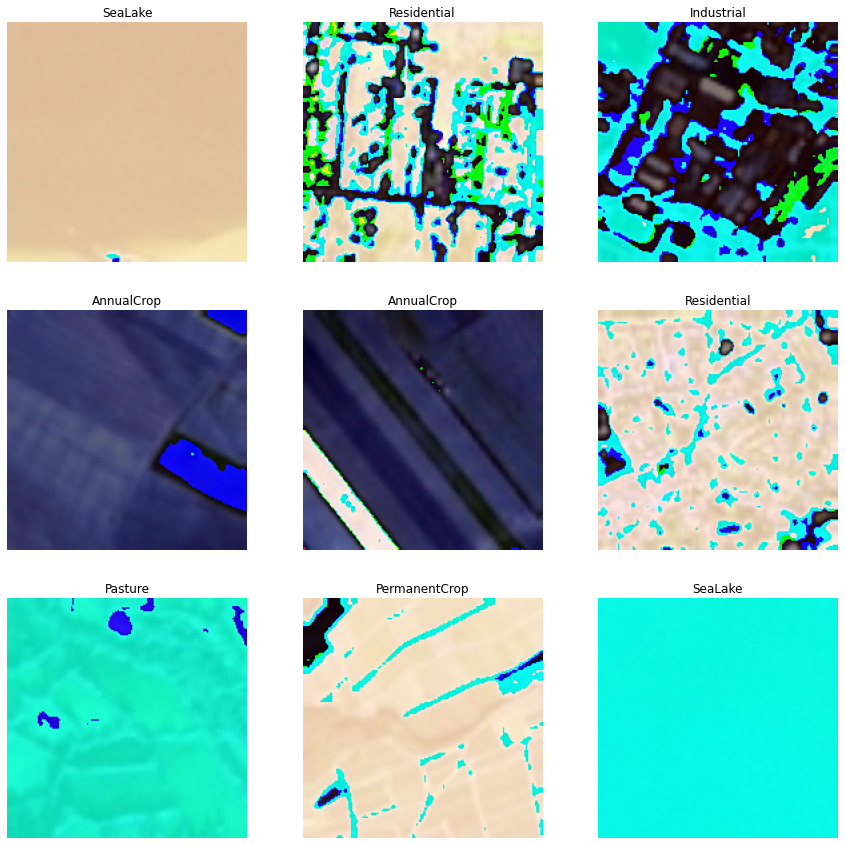

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  for datapoint in tfds.as_numpy(train_dataset.take(1)):
    plt.imshow(datapoint[0][0].astype('uint8'))
    plt.title(class_names[datapoint[1][0]])
    plt.axis("off")

plt.show()

Without using uint8

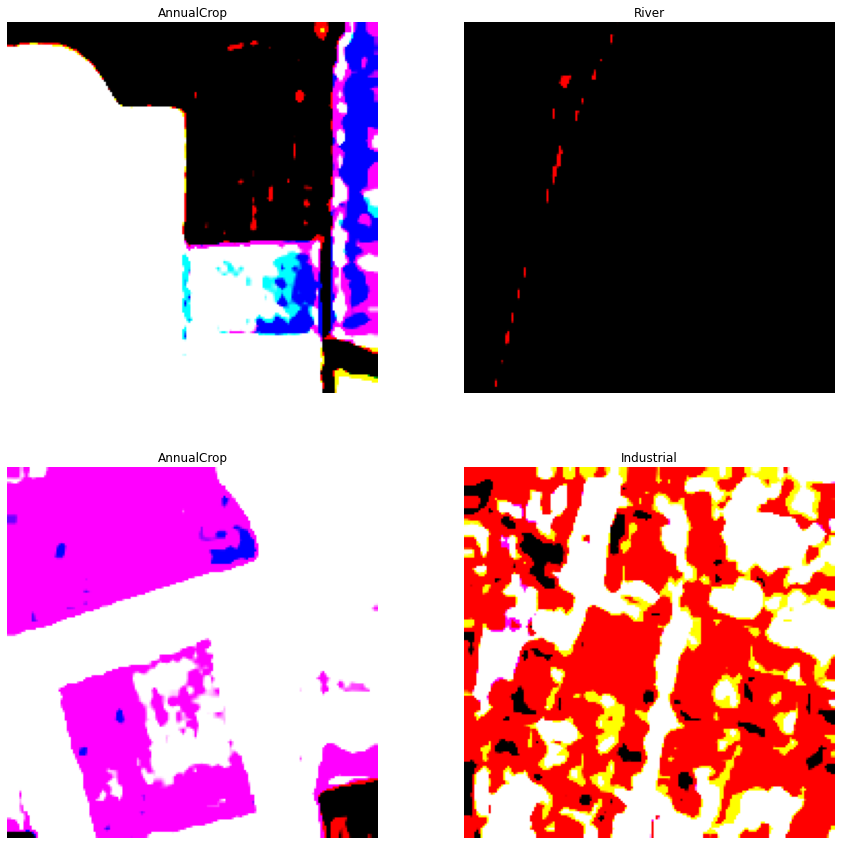

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  for datapoint in tfds.as_numpy(train_dataset.take(1)):
    plt.imshow(datapoint[0][0])
    plt.title(class_names[datapoint[1][0]])
    plt.axis("off")

plt.show()

## **Building model**

In [ ]:
resnet = ResNet50(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

for layer in resnet.layers:
  layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predicition = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=resnet.input, outputs=predicition)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
STEPS_PER_EPOCH = int(info.splits["train"].num_examples * 0.8)//BATCH_SIZE
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1)//BATCH_SIZE

In [ ]:
history = model.fit(
    train_dataset,
    epochs = NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
168/168 [==============================] - 139s 617ms/step - loss: 0.4830 - accuracy: 0.8501 - val_loss: 0.1669 - val_accuracy: 0.9464
Epoch 2/5
168/168 [==============================] - 103s 604ms/step - loss: 0.1194 - accuracy: 0.9602 - val_loss: 0.1343 - val_accuracy: 0.9572
Epoch 3/5
168/168 [==============================] - 101s 604ms/step - loss: 0.0819 - accuracy: 0.9708 - val_loss: 0.1233 - val_accuracy: 0.9594
Epoch 4/5
168/168 [==============================] - 101s 604ms/step - loss: 0.0526 - accuracy: 0.9823 - val_loss: 0.1471 - val_accuracy: 0.9591
Epoch 5/5
168/168 [==============================] - 102s 605ms/step - loss: 0.0490 - accuracy: 0.9841 - val_loss: 0.1447 - val_accuracy: 0.9624


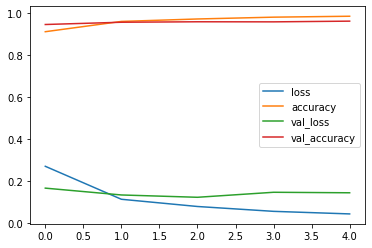

In [ ]:
import pandas as pd

pd.DataFrame(
    history.history
).plot()

## **Evaluating results**

In [ ]:
test_dataset = test.map(prepare_validation_data)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
_, accuracy = model.evaluate(test_dataset)

22/22 [==============================] - 12s 503ms/step - loss: 0.1570 - accuracy: 0.9463


In [ ]:
accuracy = round(accuracy*100,2)

In [ ]:
print(accuracy)

94.63


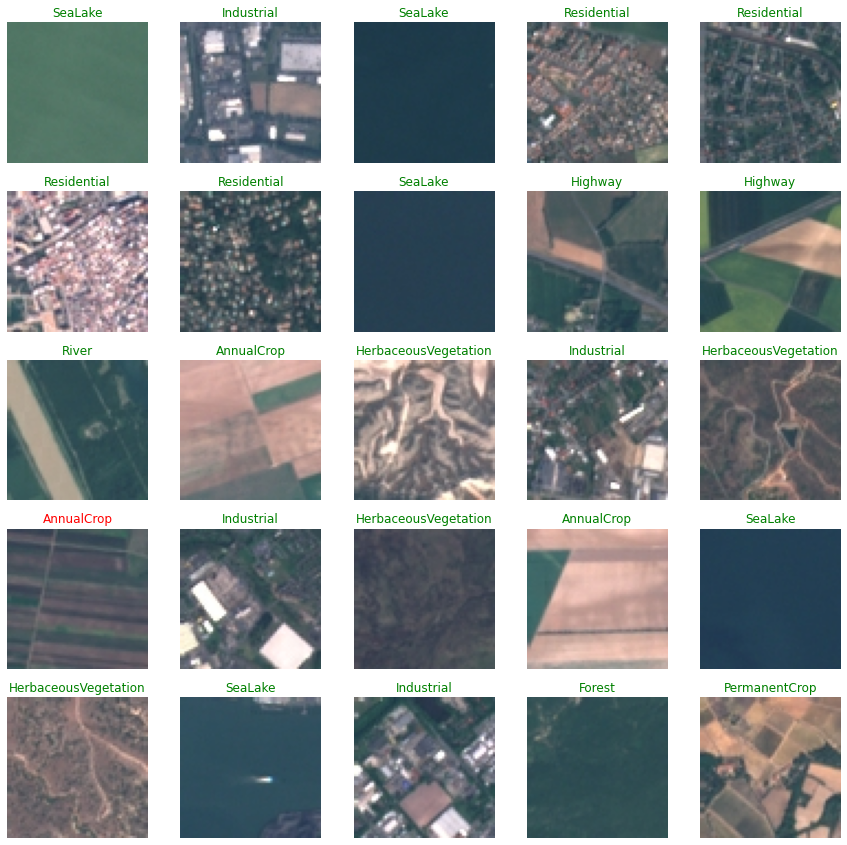

In [ ]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)

  if datapoint["label"] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()

In [ ]:
model_save_name = F'CNN_Eurosat_classifier(ResNet50){accuracy}%.pt'
path = F"/content/gdrive/MyDrive/Models/{model_save_name}" 


In [ ]:
model.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Models/CNN_Eurosat_classifier(ResNet50)94.63%.pt/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Models/CNN_Eurosat_classifier(ResNet50)94.63%.pt/assets
